In [34]:
#Supress Warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import xarray as xr
from herbie import Herbie
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from geographiclib.geodesic import Geodesic
import metpy.constants as const
import metpy.calc as mpcalc
from metpy.units import units
import scipy.interpolate as interps
from scipy.interpolate import RegularGridInterpolator
from glob import glob
import os

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

def get_dx_dy(meso_lon,meso_lat,ob_lon,ob_lat):
    res = Geodesic.WGS84.Inverse(meso_lat, meso_lon,ob_lat, ob_lon)
    dx = res['s12']*np.sin(np.radians(res['azi1']))
    dy = res['s12']*np.cos(np.radians(res['azi1']))
    return dx,dy
    
def subset_data_km(clat, clon, lat2d, lon2d, data2d, dlat_km, dlon_km):
    """Subset a curvilinear grid within +/- dlat_km north/south and +/- dlon_km east/west."""
    lat2d = np.asarray(lat2d); lon2d = np.asarray(lon2d); data2d = np.asarray(data2d)

    # normalize longitudes to the convention of clon
    def wrap_like(lon, ref):
        if np.nanmax(lon) > 180:
            lon = lon % 360.0
            ref = ref % 360.0
        else:
            lon = ((lon + 180) % 360) - 180
            ref = ((ref + 180) % 360) - 180
        return lon, ref
    lon2d, clon = wrap_like(lon2d, clon)

    # simple local equirectangular approximation (fine over a few hundred km)
    deg2km = 111.32
    coslat = np.cos(np.deg2rad(clat))
    dx_km = ( ((lon2d - clon + 180) % 360) - 180 ) * coslat * deg2km
    dy_km = (lat2d - clat) * deg2km

    m = (np.abs(dx_km) <= dlon_km) & (np.abs(dy_km) <= dlat_km)
    if not np.any(m):
        raise ValueError("No grid points fell inside the requested km box.")

    i_idx, j_idx = np.where(m)
    i0, i1 = i_idx.min(), i_idx.max()
    j0, j1 = j_idx.min(), j_idx.max()
    return (lat2d[i0:i1+1, j0:j1+1],
            lon2d[i0:i1+1, j0:j1+1],
            data2d[i0:i1+1, j0:j1+1])

def interp_columns_to_uniform_z(p_z, z3d, th3d, qv3d, u3d, v3d, zmax=20000.0, dz=100.0):
    """
    Interpolate each (y,x) column to a uniform height grid starting at z=0.
    
    Inputs
    ------
    p_z   : (nz,)           pressure [Pa] at each model level (same levels as first dim of z3d)
    z3d   : (nz, ny, nx)    geopotential height [m], monotonic increasing in z for each (y,x)
    th3d  : (nz, ny, nx)    potential temperature [K]
    qv3d  : (nz, ny, nx)    water vapor mixing ratio [kg/kg]
    u3d   : (nz, ny, nx)     Zonal wind component [m/s]
    v3d   : (nz, ny, nx)     Meridional wind component [m/s]
    zmax  : float           top of uniform grid [m]
    dz    : float           vertical spacing [m]

    Returns
    -------
    z_target : (nz_t,)          uniform heights [m] from 0 to zmax
    p_uni    : (nz_t, ny, nx)   pressure [Pa] on z_target (log-linear interp)
    th_uni   : (nz_t, ny, nx)   theta [K] on z_target (linear)
    qv_uni   : (nz_t, ny, nx)   qv [kg/kg] on z_target (linear)
    psfc     : (ny, nx)         pressure at z=0 [Pa]
    th0      : (ny, nx)         theta at z=0 [K]
    qv0      : (ny, nx)         qv at z=0 [kg/kg]
    """
    nz, ny, nx = z3d.shape
    z_target = np.arange(0.0, zmax + 1e-9, dz)

    # ---- z=0 crossing per column (same logic you already have) ----
    z0 = z3d[:-1]                 # (nz-1, ny, nx)
    z1 = z3d[1:]                  # (nz-1, ny, nx)
    cross = (z0 <= 0.0) & (z1 >= 0.0)
    k_cross = cross.argmax(axis=0)            # (ny, nx)
    has_cross = cross.any(axis=0)
    caseA = z3d[0]  >= 0.0                    # entire column above 0
    caseB = z3d[-1] <= 0.0                    # entire column below 0
    k = np.where(has_cross, k_cross, np.where(caseA, 0, nz-2))  # bracketing k

    jj, ii = np.meshgrid(np.arange(ny), np.arange(nx), indexing="ij")
    zk  = z3d[k,   jj, ii]
    zk1 = z3d[k+1, jj, ii]
    denom = (zk1 - zk)
    w0 = np.where(np.abs(denom) > 0, (-zk) / denom, 0.0)

    def interp0(f3d):
        fk  = f3d[k,   jj, ii]
        fk1 = f3d[k+1, jj, ii]
        return fk + w0 * (fk1 - fk)

    # z=0 values
    psfc = interp0(p_z[:, None, None].repeat(ny, axis=1).repeat(nx, axis=2))
    th0  = interp0(th3d)
    qv0  = interp0(qv3d)
    u0  = interp0(u3d)
    v0  = interp0(v3d)

    # ---- Build per-column z and fields including z=0, then interpolate to uniform grid ----
    # For each column, create column arrays: z_col (length nz+1), th_col, qv_col, p_col(=p_z)
    # Insert z=0 between k and k+1 with the interpolated values.
    # We’ll interpolate to z_target using np.interp (linear), except pressure in log-space.

    # Flatten columns for vectorized loops
    ncol = ny * nx
    zcol = z3d.reshape(nz, ncol)            # (nz, ncol)
    thcol = th3d.reshape(nz, ncol)
    qvcol = qv3d.reshape(nz, ncol)
    ucol  = u3d.reshape(nz, ncol)
    vcol  = v3d.reshape(nz, ncol)
    k_flat = k.reshape(ncol)
    psfc_flat = psfc.reshape(ncol)
    th0_flat = th0.reshape(ncol)
    qv0_flat = qv0.reshape(ncol)
    u0_flat = u0.reshape(ncol)
    v0_flat = v0.reshape(ncol)

    # Output containers
    nzt = len(z_target)
    th_uni = np.empty((nzt, ncol), dtype=th3d.dtype)
    qv_uni = np.empty((nzt, ncol), dtype=qv3d.dtype)
    p_uni  = np.empty((nzt, ncol), dtype=p_z.dtype)
    u_uni  = np.empty((nzt, ncol), dtype=p_z.dtype)
    v_uni  = np.empty((nzt, ncol), dtype=p_z.dtype)

    # Pre-compute ln(p) for log-linear pressure interpolation
    ln_p = np.log(np.maximum(p_z, 1.0))     # avoid log(0)

    for c in range(ncol):
        kc = k_flat[c]

        # Assemble column z including the interpolated z=0 level
        # z_col_full: [..., z[kc], 0, z[kc+1], ...]
        z_before = zcol[:kc+1, c]
        z_after  = zcol[kc+1:, c]
        z_full   = np.concatenate([z_before, np.array([0.0]), z_after])

        # Corresponding theta/qv with z=0 value inserted
        th_full  = np.concatenate([thcol[:kc+1, c], np.array([th0_flat[c]]), thcol[kc+1:, c]])
        qv_full  = np.concatenate([qvcol[:kc+1, c], np.array([qv0_flat[c]]), qvcol[kc+1:, c]])
        u_full   = np.concatenate([ucol[:kc+1, c], np.array([u0_flat[c]]), ucol[kc+1:, c]])
        v_full   = np.concatenate([vcol[:kc+1, c], np.array([v0_flat[c]]), vcol[kc+1:, c]])

        # Pressure at native levels is p_z (same for all columns); at z=0 use psfc for this column.
        # Build ln(p) vector with ln(psfc) inserted at z=0.
        ln_p_full = np.concatenate([ln_p[:kc+1], np.array([np.log(psfc_flat[c])]), ln_p[kc+1:]])

        # Ensure strictly increasing z for np.interp; if any duplicate z, nudge the 0 by 1e-6
        # (Usually z is strictly increasing; this is just a guard.)
        if kc > 0 and np.isclose(z_full[kc], 0.0) and np.isclose(z_full[kc+1], 0.0):
            z_full[kc+1] = 1e-6

        # Clip z_target to the available column span to avoid extrapolation surprises
        zmin, zmax_col = z_full[0], z_full[-1]
        zt = np.clip(z_target, zmin, zmax_col)

        # Linear interp for theta/qv; log-linear for pressure
        th_uni[:, c] = np.interp(zt, z_full, th_full)
        qv_uni[:, c] = np.interp(zt, z_full, qv_full)
        u_uni[:, c]  = np.interp(zt, z_full, u_full)
        v_uni[:, c]  = np.interp(zt, z_full, v_full)
        p_uni[:,  c] = np.exp(np.interp(zt, z_full, ln_p_full))

    # Reshape back to (nzt, ny, nx)
    th_uni = th_uni.reshape(nzt, ny, nx)
    qv_uni = qv_uni.reshape(nzt, ny, nx)
    p_uni  = p_uni.reshape(nzt, ny, nx)
    u_uni  = u_uni.reshape(nzt, ny, nx)
    v_uni  = v_uni.reshape(nzt, ny, nx)

    return z_target, p_uni, th_uni, qv_uni, u_uni, v_uni, psfc, th0, qv0


def make_hrrr_dataset(date_init,clat,clon,dx,dy,path='HRRR/'):
    H = Herbie(date_init.strftime('%Y-%m-%d %H:%M'),model='hrrr',product='prs',fxx=0)
    
    #Grab the available levels
    try:
        ds1 = H.inventory()
    except ValueError: #Meaning no HRRR data for this date
        return
    alevels = np.unique(ds1.level.values)
    levels = []
    for val in alevels:
        if ('mb' in val) and ('-' not in val):
            levels.append(float(val.split()[0]))
    
    levels = np.sort(levels)[::-1]
    
    level_str = []
    for val in levels:
        if val == 1013.2:
            level_str.append(':{} mb'.format(val))
        else:
            level_str.append(':{} mb'.format(int(val)))
    
    
    
    file_name = path+'/{}.nc'.format(date_init.strftime('%Y%m%d'))
    if not os.path.exists(file_name):
        for al in tqdm(range(len(levels))):
            try:
                ds = H.xarray(level_str[al])
                
                latitudes,longitudes = ds.latitude.values,ds.longitude.values-360
                
                #Get variables we want
                lat_slice,lon_slice,t = subset_data_km(clat,clon,latitudes,longitudes,ds.t.values,dy,dx)
                lat_slice,lon_slice,u = subset_data_km(clat,clon,latitudes,longitudes,ds.u.values,dy,dx)
                lat_slice,lon_slice,v = subset_data_km(clat,clon,latitudes,longitudes,ds.v.values,dy,dx)
                lat_slice,lon_slice,q = subset_data_km(clat,clon,latitudes,longitudes,ds.q.values,dy,dx)
                lat_slice,lon_slice,gh = subset_data_km(clat,clon,latitudes,longitudes,ds.gh.values,dy,dx)
                lat_slice,lon_slice,r = subset_data_km(clat,clon,latitudes,longitudes,ds.r.values,dy,dx)
                lat_slice,lon_slice,dpt = subset_data_km(clat,clon,latitudes,longitudes,ds.dpt.values,dy,dx)

                #Write this to a netCDF file
                if al == 0:
                    try: ncfile.close()  # just to be safe, make sure dataset is not already open.
                    except: pass
                    ncfile = Dataset(file_name,mode='w',format='NETCDF4_CLASSIC')
                    
                    #Make the dimensions
                    y_dim = ncfile.createDimension('y', lat_slice.shape[1])     # latitude axis
                    x_dim = ncfile.createDimension('x', lat_slice.shape[0])    # longitude axis
                    height_dim = ncfile.createDimension('z', len(levels))    # longitude axis
                    
                    #Make the variable names---------------------
                    lat = ncfile.createVariable('y', np.float32, ('x','y',))
                    lat.units = 'meters_north'
                    lat.long_name = 'y-dim'
                    lat[:] = lat_slice
                    
                    lon = ncfile.createVariable('x', np.float32, ('x','y',))
                    lon.units = 'meters_east'
                    lon.long_name = 'x-dim'
                    lon[:] = lon_slice
                    
                    height = ncfile.createVariable('z', np.float32, ('z',))
                    height.units = 'meters_up'
                    height.long_name = 'z-dim'
                    height[:] = levels
            
                    #Make all the variables
                    atemp = ncfile.createVariable('temp',np.float64,('z','x','y'))
                    au = ncfile.createVariable('u',np.float64,('z','x','y'))
                    av = ncfile.createVariable('v',np.float64,('z','x','y'))
                    aq = ncfile.createVariable('q',np.float64,('z','x','y'))
                    agh = ncfile.createVariable('gh',np.float64,('z','x','y'))
                    ar = ncfile.createVariable('r',np.float64,('z','x','y'))
                    adpt = ncfile.createVariable('dpt',np.float64,('z','x','y'))
                    
            
                #Append the variables
                atemp[al,:,:] = t
                au[al,:,:] = u
                av[al,:,:] = v
                aq[al,:,:] = q
                agh[al,:,:] = gh
                ar[al,:,:] = r
                adpt[al,:,:] = dpt
            except FileNotFoundError:
                print(':{} mb'.format(int(levels[al])))
        ncfile.close()
        return
    else:
        return

def make_input_sounding_file(hrr_to_cm1_out,out_nc_path):
    # Pull and cast
    x = np.asarray(hrr_to_cm1_out['x'], dtype=np.float64)
    y = np.asarray(hrr_to_cm1_out['y'], dtype=np.float64)
    z = np.asarray(hrr_to_cm1_out['z'], dtype=np.float64)
    
    theta = np.asarray(hrr_to_cm1_out['theta'], dtype=np.float32)
    qv    = np.asarray(hrr_to_cm1_out['qv'],    dtype=np.float32)
    u     = np.asarray(hrr_to_cm1_out['u'],     dtype=np.float32)
    v     = np.asarray(hrr_to_cm1_out['v'],     dtype=np.float32)
    
    psfc  = np.asarray(hrr_to_cm1_out['psfc'],  dtype=np.float32)
    th0   = np.asarray(hrr_to_cm1_out['th0'],   dtype=np.float32)
    qv0   = np.asarray(hrr_to_cm1_out['qv0'],   dtype=np.float32)
    
    nz, ny, nx = theta.shape
    # Shape checks (fail fast, clear errors)
    assert (nz, ny, nx) == qv.shape == u.shape == v.shape, "3D arrays must share (nz,ny,nx)"
    assert (ny, nx) == psfc.shape == th0.shape == qv0.shape, "2D arrays must share (ny,nx)"
    assert x.shape == (nx,) and y.shape == (ny,) and z.shape == (nz,), "Coord lengths must match data dims"
    
    # Create file
    nc = Dataset(out_nc_path, 'w', format='NETCDF4')
    
    # Global attrs
    nc.title = 'Initial conditions from 3D analysis data'
    
    # Dimensions
    nc.createDimension('xh', nx)
    nc.createDimension('yh', ny)
    nc.createDimension('zh', nz)
    
    # Coordinates (double like your ncdump)
    vx = nc.createVariable('xh', 'f8', ('xh',))
    vy = nc.createVariable('yh', 'f8', ('yh',))
    vz = nc.createVariable('zh', 'f8', ('zh',))
    vx[:] = x; vy[:] = y; vz[:] = z
    
    # Helper for compressed vars
    def make_var(name, dims):
        # modest chunking; tweak if needed
        chunks = None
        if len(dims) == 3:
            chunks = (min(nz, 32), min(ny, 64), min(nx, 64))
        elif len(dims) == 2:
            chunks = (min(ny, 128), min(nx, 128))
        return nc.createVariable(
            name, 'f4', dims,
            zlib=True, complevel=2, chunksizes=chunks,
            fill_value=np.float32(np.nan)
        )
    
    # Data vars (match (zh,yh,xh) layout)
    vtheta = make_var('theta', ('zh','yh','xh')); vtheta[:, :, :] = theta
    vqv    = make_var('qv',    ('zh','yh','xh')); vqv[:, :, :]    = qv
    vu     = make_var('u',     ('zh','yh','xh')); vu[:, :, :]     = u
    vv     = make_var('v',     ('zh','yh','xh')); vv[:, :, :]     = v
    
    vpsfc  = make_var('psfc',  ('yh','xh'));      vpsfc[:, :]     = psfc
    vth0   = make_var('th0',   ('yh','xh'));      vth0[:, :]      = th0
    vqv0   = make_var('qv0',   ('yh','xh'));      vqv0[:, :]      = qv0
    
    # Optional: attach simple attributes (units, notes)
    vtheta.units = 'K'
    vqv.units    = 'kg kg-1'   # or g kg-1 if that’s what you stored
    vu.units = vv.units = 'm s-1'
    vpsfc.units  = 'Pa'        # or hPa if that’s your choice
    vth0.units   = 'K'
    vqv0.units   = 'kg kg-1'
    vx.units = vy.units = 'm'
    vz.units = 'm'
    
    nc.close()
    return
    

#Define some constants
Rd  = const.dry_air_gas_constant.m
Rv  = const.water_gas_constant.m
cpd = const.dry_air_spec_heat_press.m
g   = const.earth_gravity.m
p0  = 1000 #hPa


In [30]:
#Put in your date of interest here - I have it pull 4 hours prior to run simulations with
date_init = datetime(2024, 4, 6, 22, 0)
dt = hour_rounder(date_init)-timedelta(hours=4) #4 hours before reference time (change if needed)
clat,clon = 35.25,-97.45
dx,dy = 100,100 #km, domain of the model analysis grid relative to the point of interest
path = 'HRRR/' #Directory to house the netCDF file
out_nc_path = '../cm1/input_sounding.nc' #Path to store the input_sounding.nc file
make_hrrr_dataset(dt,clat,clon,dx,dy,path=path)


✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-Apr-06 18:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


  0%|          | 0/40 [00:00<?, ?it/s]

In [36]:
#Open the HRRR dataset
hrr_to_cm1_out = {}
ds = xr.open_dataset(path+'/{}.nc'.format(dt.strftime('%Y%m%d'))) #[z,y,x]

# Make a square grid of the HRRR coordinates (y,x)
hrrr_x,hrrr_y = np.linspace(-dx,dx,ds.x.values.shape[1],endpoint=True),np.linspace(-dy,dy,ds.x.values.shape[0],endpoint=True)

#Make 3D pressure array
hrrr_prs = ds.z.values
pres_levs_3d = np.broadcast_to(hrrr_prs.reshape(hrrr_prs.size, 1, 1), (hrrr_prs.size,hrrr_y.size,hrrr_x.size))


#Compute potential temperature and WVMR
exner = (p0 / pres_levs_3d) ** (Rd / cpd)
theta = ds.temp.values * exner

#Compute WVMR
qv = mpcalc.mixing_ratio_from_relative_humidity(np.array(pres_levs_3d)*units.hPa, np.array(ds.temp.values)*units.kelvin, np.array(ds.r.values)*units.percent).m*1000 #g/kg

#Get the surface variables and interpolate to common grid
zmax = 16000.0 #meters
z_arr,_,th_arr,qv_arr,u_arr,v_arr,psfc,th0,qv0 = interp_columns_to_uniform_z(hrrr_prs, ds.gh.values, theta, qv, ds.u.values, ds.v.values, zmax=zmax)

#Append the dimensions
hrr_to_cm1_out['x'] = hrrr_x*1000 #meters
hrr_to_cm1_out['y'] = hrrr_y*1000 #meters
hrr_to_cm1_out['z'] = z_arr #meters

#Append the needed variables #[z,y,x]
hrr_to_cm1_out['theta'] = th_arr
hrr_to_cm1_out['qv'] = qv_arr
hrr_to_cm1_out['u'] = u_arr
hrr_to_cm1_out['v'] = v_arr
hrr_to_cm1_out['psfc'] = psfc
hrr_to_cm1_out['th0'] = th0
hrr_to_cm1_out['qv0'] = qv0

#Make the input_sounding file
make_input_sounding_file(hrr_to_cm1_out,out_nc_path)


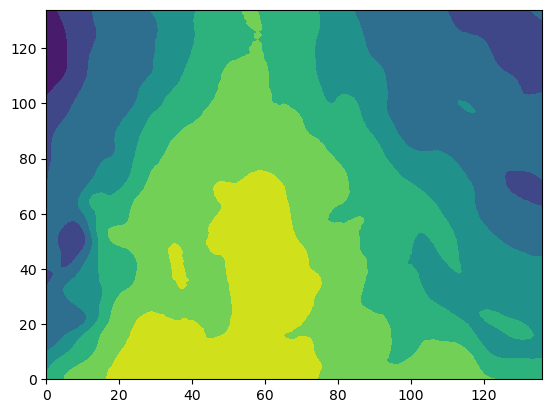

In [12]:
#Make a plot if wanted
plt.contourf(hrr_to_cm1_out['qv'][0])